In [1]:
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Section 0 - References

* Scikit-Learn documentation: http://scikit-learn.org/0.14/modules/generated/sklearn.linear_model.LinearRegression.html
* http://en.wikipedia.org/wiki/Goodness_of_fit
* http://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [2]:
#Load the data
df = pd.read_csv('improved-dataset/turnstile_weather_v2.csv')

# Section 1 - Statistical Test

###1.1
A Mann-Whitney U test was used to test the null hypothesis that the two samples (with and without rain) are from the same population.  A two-tailed test was used to estimate the probability of the null hypothesis relative to the alternative hypothesis that the number of hourly entries is more extreme (higher or lower) when it is raining.  The p-critical value is 0.05, indicating a maximum of 5% chance that the two samples are from the same population.

###1.2

The number of hourly entries is likely to be bounded on both sides- they must be above zero because negative entries are nonsensical, and there must be some upper limit to the number of entries per hour in each turnstile because riders can only move so quickly (thus limiting the number of entries monitored by a single unit).

The hourly entries were split into Non-Rainy and Rainy subsets ('rain' = 0 or 1 respectively). Probability plots of these subsets are shown below.  Neither is normal largely because of the lower bound on the probability distribution, but also because there is a long upper tail of measurements with high values.  Therefore statistical tests that assume normality (like Welch's t-test) cannot not be used.  The Mann-Whitney U test was used because it doesn't assume normality and its other assumptions are met- the samples are unpaired with similar distributions and the data is ordinal.

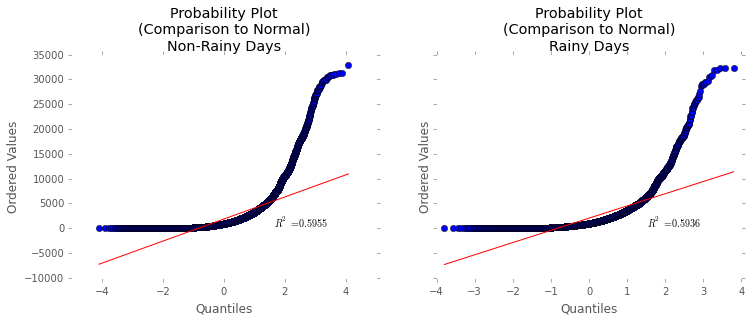

In [3]:
with_rain = df[df['rain']==1]['ENTRIESn_hourly']
without_rain = df[df['rain']==0]['ENTRIESn_hourly']
fig,axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
scipy.stats.probplot(without_rain , plot=axes[0])
scipy.stats.probplot(with_rain , plot=axes[1])

axes[0].set_title('Probability Plot\n(Comparison to Normal)\nNon-Rainy Days')
axes[1].set_title('Probability Plot\n(Comparison to Normal)\nRainy Days')

###1.3
The calculated test statistic has a two-tailed p-value of 0.00000548, far below the critical p-value.  The occurence of rain increased the average number of subway entries per hour by about 9.9%- from 1845.54 per hour to 2028.20 per hour.

In [4]:
with_rain = df[df['rain']==1]['ENTRIESn_hourly']
without_rain = df[df['rain']==0]['ENTRIESn_hourly']
U,p = scipy.stats.mannwhitneyu(with_rain,without_rain)
p *= 2 #For two-tailed
print("U = {}\np = {:.8f}\nMean (with Rain) = {:.2f}\nMean (without Rain) = {:.2f}"\
      .format(U, p, with_rain.mean(), without_rain.mean()))

U = 153635120.5
p = 0.00000548
Mean (with Rain) = 2028.20
Mean (without Rain) = 1845.54


###1.4
There appears to be a statistically significant difference in entries to the subway when it is raining.  Specifically, there is about a 10% increase on average.

# Section 2- Linear Regression

###2.1
A - OLS Linear Regression with Scikit-learn:

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

def linear_regression(features, values):
    """
    Performs linear regression given a dataset with an arbitrary number of features using scikit-learn
    """

    # instantiate and fit
    lm = LinearRegression()
    lm.fit(features, values)
    
    #Rsquared value
    print("Coefficient of Determination (R^2) = {:.4}".format(lm.score(features, values)))
    
    return lm.intercept_, lm.coef_

def predictions(dataframe):
    '''
    Make predictions based on linear regression.
    '''
    # Select Features
    features = dataframe[['precipi', 'pressurei', 'tempi']]
    
    # Add dummy variables
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_day_week = pd.get_dummies(dataframe['day_week'], prefix='dw')
    dummy_hour = pd.get_dummies(dataframe['hour'], prefix='hour')
    features = pd.concat([features, dummy_units, dummy_day_week, dummy_hour], axis=1)
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    
    # Get the numpy arrays
    features_array = features.values
    values_array = values.values

    # Perform linear regression
    intercept, params = linear_regression(features_array, values_array)
    
    predictions = intercept + np.dot(features_array, params)
    print(intercept, params[:3])
    return predictions

pred = predictions(df)

Coefficient of Determination (R^2) = 0.5457
13269.6411333 [-2017.29385914  -349.17224788   -15.53203689]


###2.2
Features:

* precipi - precipitation in inches at the time and location
* pressurei - barometric pressure in inches HG at the time and location
* tempi - temperature in degrees F at the time and location

Dummy Variables:

* UNIT - represents several turnstiles, possibly from the same station
* day_week - day of the week
* hour - hour of the day

###2.3
All three features used were aspects of the weather.  In particular, they were specific measurements rather than relative measurements.  For example, the precipitation in inches was a bit more informative (resulted in a slightly better coefficient of determination) than the 'rain' variable.  This isn't surprising since the rain variable doesn't distinguish between a very light rain at a different time in the same day and a downpour at the time of measurement.

The dummy variables related to typical use of the turnstiles.  It is reasonable to expect that a given group of turnstiles (within a unit) will have similar traffic at a given time and day each week.  The 'UNIT' feature in particular was very effective at increasing the R^2 value.

###2.4
* precipi = -2017.294
* pressurei = -349.172
* tempi = -15.532

###2.5
R^2 = .5457

###2.6
An R^2 value of .5457 means that the fitted model explains about 55% of the variance in the outcome variable (number of entries per hour).  This could be useful for applications that don't need to be too specific, but shouldn't be used to attempt highly accurate predictions of ridership numbers.  Examining the residuals (done below in section 5) would be more useful to judge the prediction accuracy.

An important consideration is that a large portion of the R^2 value was contributed by looking at which unit was collecting data.  This means:

* A much simpler model (looking at average entries for a given UNIT) may be appropriate to get rough estimates of ridership that are almost as good.
* This model is tightly fit to the given dataset.  Data collected from other units would require a newly fit model.

# Section 3 - Visualization

###Figure 1

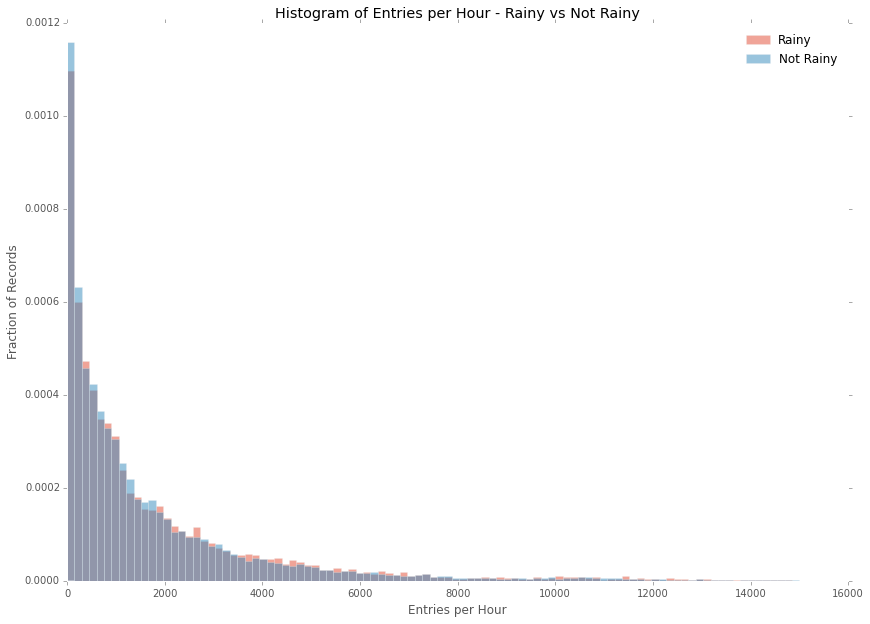

In [6]:
fig,ax = plt.subplots(1, figsize=(14,10))
bins = np.linspace(0,15000,100)
df[df['rain']==1].hist(column='ENTRIESn_hourly', normed=True, histtype='bar',
                       bins=bins, ax=ax, label='Rainy', alpha=0.5)
df[df['rain']==0].hist(column='ENTRIESn_hourly', normed=True, histtype='bar',
                       bins=bins, ax=ax, label='Not Rainy', alpha=0.5)
ax.legend(loc='best')
ax.set_title('Histogram of Entries per Hour - Rainy vs Not Rainy')
ax.set_ylabel('Fraction of Records')
ax.set_xlabel('Entries per Hour')

This histogram comparison shows the distribution of records with different values for the number of entries per hour.  The area is normalized to be equal for both records from days with rain and days without rain.  The key insight is that rainy days tend to have a lower proportion of records with a small number of entries (for example, 0 to 300).  Other than this the difference is subtle, but it does seem to provide some basic evidence that rain increases the number of entries.

###Figure 2

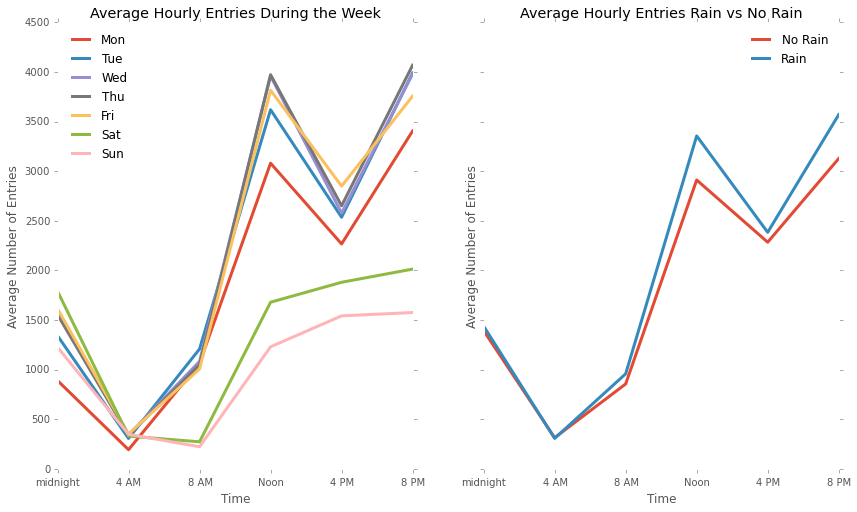

In [7]:
fig,ax = plt.subplots(1,2, figsize=(14,8), sharey = True)

#Left Plot
data = df.pivot_table(values='ENTRIESn_hourly', index='hour',columns='day_week')
data.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
data.index = ['midnight','4 AM', '8 AM', 'Noon', '4 PM', '8 PM']

data.plot(lw=3, ax=ax[0])

ax[0].set_title('Average Hourly Entries During the Week')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Average Number of Entries')

#Right Plot
data = df.pivot_table(values='ENTRIESn_hourly', index='hour',columns='rain')
data.columns = ['No Rain', 'Rain']
data.index = ['midnight','4 AM', '8 AM', 'Noon', '4 PM', '8 PM']

data.plot(lw=3, ax=ax[1])

ax[1].set_title('Average Hourly Entries Rain vs No Rain')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Average Number of Entries')

The left portion of this plot shows how the average number of entries per hour changes over time- during the week and throughout the day.  As might be expected, ridership is much higher during the week.  During the week ridership is highest at Noon and 8pm, while weekend ridership follows a different trend- increasing from 8 AM before leveling off between 8 PM and midnight.

The right portion of the plot shows a similar comparison but uses the rain variable to distinguish the trends instead of the day of the week.  Interestingly, the effect of rain appears to small in the early morning hours and larger during the day.  However, the extent of the increase appears to be similar to or even less than the difference in ridership from day to day during the week.

# Section 4 - Conclusion

###4.1

Based on the available data there appears to be a small (roughly 10% on average) but statistically significant increase in ridership when it rains.  However, this conclusion applies only to ridership throughout May 2011 at the stations that were measured.  It is possible that other variables influence ridership (the linear regression only captured about 55% of the variance).

###4.2

The statistical test that was used (Mann-Whitney U) showed that the null hypothesis is unlikely compared to the alternative hypothesis (that the distribution of ridership values is different when it rains).  The linear regression model actually has a large negative coefficient for the precipitation feature.  However, when fewer features are used (specifically day of the week and time of day) the coefficient is positive.  In either case when the rain variable (or precipi, which provides similar but more detailed information) is used the linear regression is more predictive (higher coefficient of determination).  The second visualiation was especially clear, showing that average ridership during rainy days is greater than or equal to average ridership on dry days no matter the time of day.  It is important to note that this visual comparison is based only on average values and therefore wouldn't be statistically meaningful without the significant p-value obtained in the test.

# Section 5 - Reflection

###5.1
The dataset is limited in that it only contains data over the course of a single month (May 2011).  It's possible that temporary effects (holidays, sporting events, etc) could have affected ridership numbers, or that this period of time doesn't provide a representative sampling of possible weather conditions.  

It is reasonable to expect that the time of measurement (date and time of day) has a large effect on the ridership numbers.  However, measuring over the course of a month is limiting for looking at the day of the week since each day will only occur 4 to 5 times in the sample.  When combined with the weather conditions this is especially limiting.  If rainy days happened to occur during the week and not on the weekend this would give the appearance of increased ridership on rainy days simply because weekend ridership is lower.  Similarly, the effect of rain may be understated if rain tended to occur on the weekends.

The linear regression model also has some shortcomings.  The residuals are not normally distributed- a long tail on the upper end indicates that many measurements were much higher than expected.  Looking at the results in greater detail using a scatterplot of actual vs predicted values reveals two more significant issues.  The model sometimes predicts negative values (which is nonsensical for hourly entries) and the highest prediction is 12,045 hourly entries, which is roughly a third of the highest actual value (32,814).  This could indicate that one or more features do not have a linear relationship with the number of hourly entries.

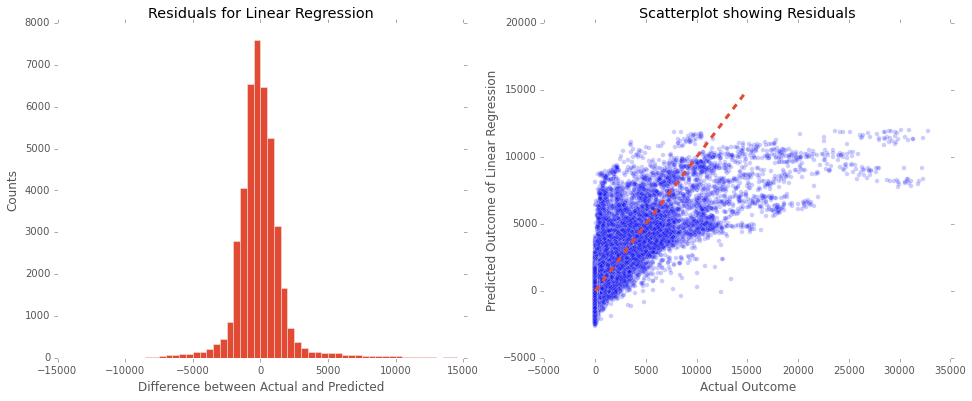

In [8]:
fig,axes = plt.subplots(1, 2, figsize=(16,6))
residuals = (df['ENTRIESn_hourly'] - pred)

residuals.hist(bins=range(-15000,15000,500), ax=axes[0])
axes[1].scatter(x=df['ENTRIESn_hourly'], y=pred, alpha=0.2)
axes[1].plot([0,15000],[0,15000], lw=3, ls='--')

axes[0].set_title('Residuals for Linear Regression')
axes[0].set_xlabel('Difference between Actual and Predicted')
axes[0].set_ylabel('Counts')
axes[1].set_title('Scatterplot showing Residuals')
axes[1].set_xlabel('Actual Outcome')
axes[1].set_ylabel('Predicted Outcome of Linear Regression')